## Github URL

---

https://github.com/Arravee/Dog_GAN

## Get the Data

We will be using the terminal commands below to downlaod the data directly. Please not that to use the Kaggle API with this method, we must first downlaod our kaggle.json file which can be found under the API section of our Kaggle profile. I will also be clearing the output of the unzip command in the final report as it takes too much space.

In [ ]:
#! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c generative-dog-images


 99% 735M/744M [00:20<00:00, 46.6MB/s]
100% 744M/744M [00:20<00:00, 37.2MB/s]


In [5]:
! unzip generative-dog-images.zip

Archive:  generative-dog-images.zip
  inflating: Annotation.zip          
  inflating: all-dogs.zip            


In [ ]:
! unzip all-dogs.zip

In [ ]:
! unzip Annotation.zip

## Problem and Dataset Description

Generative Ai image software is quickly becoming more popular. With the accessibility of programs such as Dall-E and Dream Studio, creating accurate AI-generated art in a multitude of styles is becoming easier and easier at a frightening pace. With applications in various fields from VFX to branding to custom art requests, this is a field gaining a lot of attention recently. Today we will look at generating images of dogs using GAN. The data for this project can be found here: https://www.kaggle.com/competitions/generative-dog-images/overview 
 


In [8]:
import numpy as np
import pandas as pd
import sys
import os
import multiprocessing
from datetime import datetime
import xml.etree.ElementTree as ET
from time import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from keras.layers import UpSampling2D
from keras.layers import ReLU
from keras.layers import Reshape
from keras.layers import Input

from keras.models import Sequential, Model,load_model


from sklearn.model_selection import train_test_split


## EDA

Let's take a quick look at our data. We see images and a corresponding label with the dog breed. We will write a quick loop to create 64 x 64 images of the dogs with the label attached. This will give us a nice visual overview of the data.

In [10]:
breeds = os.listdir('Annotation/') 
breeds[:10]

['n02097474-Tibetan_terrier',
 'n02092002-Scottish_deerhound',
 'n02111277-Newfoundland',
 'n02101006-Gordon_setter',
 'n02097130-giant_schnauzer',
 'n02090721-Irish_wolfhound',
 'n02089973-English_foxhound',
 'n02106550-Rottweiler',
 'n02090379-redbone',
 'n02108000-EntleBucher']

In [11]:
IMAGES = os.listdir('all-dogs/')
IMAGES[:10]

['n02088364_769.jpg',
 'n02110185_9001.jpg',
 'n02093428_5662.jpg',
 'n02102318_10019.jpg',
 'n02110958_14927.jpg',
 'n02086240_7221.jpg',
 'n02088364_876.jpg',
 'n02105162_5785.jpg',
 'n02100877_5916.jpg',
 'n02087394_9695.jpg']

In [12]:
idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))
DogsOnly = False

for breed in breeds:

    for dog in os.listdir('Annotation/' + breed):

        try: img = Image.open('all-dogs/'+ dog + '.jpg') 
        except: continue           

        tree = ET.parse('Annotation/' + breed + '/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        
        for i in objects:
            boundbox = i.find('bndbox') 
            xmin = int(boundbox.find('xmin').text)
            ymin = int(boundbox.find('ymin').text)
            xmax = int(boundbox.find('xmax').text)
            ymax = int(boundbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            #if idxIn%1000==0: print(idxIn)
            namesIn.append(breed)
            idxIn += 1



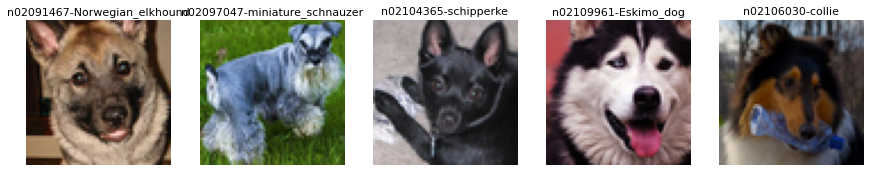

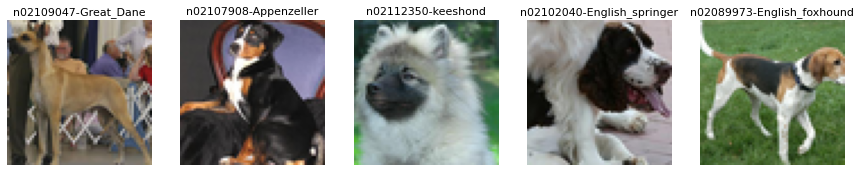

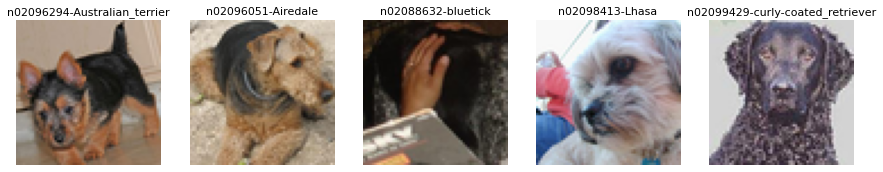

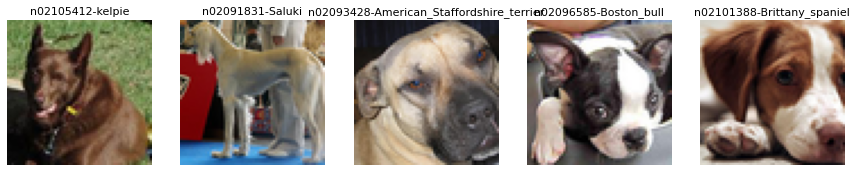

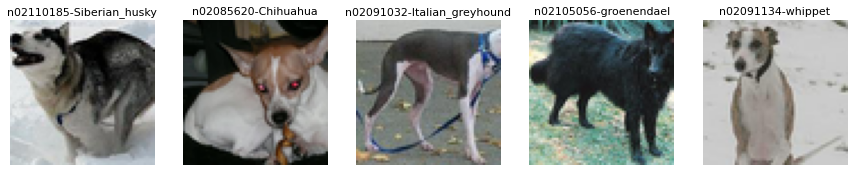

In [13]:
x = np.random.randint(0,idxIn,25)

for k in range(5):
    plt.figure(figsize=(15,3))

    for j in range(5):

        plt.subplot(1,5,j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')

        if not DogsOnly: 
            plt.title(namesIn[x[k*5+j]],fontsize=11)

        else: 
            plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
            
        plt.imshow(img)
    plt.show()

In [14]:
imagesIn.shape[0]

25000

## Dmodel Architecture

We will now move on to creating our model architecture. We will start with a relatively simple model upsampling from 4 * 4 to 64 * 64. We will also build out a discriminator, such as the one found here: https://www.kaggle.com/code/parmarsuraj99/gan-dogs-starter-biggan#Device. A discriminator in a GAN simply tries to workout real vs fake images. This is the enabler to the "adversarial" part of our GAN model. 

In [15]:
def build_generator_1():

    # Model
    model = Sequential()

    # Start at 4 * 4 and then upsample to 64 * 64
    start_shape = 64 * 4 * 4
    model.add(Dense(start_shape, kernel_initializer = init, input_dim = 128))
    model.add(Reshape((4, 4, 64)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())

    model.add(Conv2D(3, kernel_size = 3, activation = 'tanh', padding = 'same', kernel_initializer=init))
    opt = tf.keras.optimizers.Adam(0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)
    print(model.summary())

    return model


In [16]:
def build_discriminator_1():

    input_shape = (64, 64, 3)

    # Define Model and down sample back to 4 * 4
    model = Sequential()

    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init, input_shape = input_shape))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = init))

    opt = tf.keras.optimizers.Adam(0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)
    
    print(model.summary())

    return model

In [17]:
def show_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 128))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0

    for i in range(r):
        for j in range(c):
          
            axs[i,j].imshow(image.array_to_img(gen_imgs[cnt]))
            axs[i,j].axis('off')
            cnt += 1

    plt.show()
    plt.close()

In [18]:
def train(epochs, batch_size=128, save_interval=50):

    # ground truths for our model to "fight" against
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    valid[:]=0.9
    
    for epoch in range(epochs):
        
        # Select a random half of images
        idx = np.random.randint(0, imagesIn.shape[0], batch_size)
        imgs = imagesIn[idx]
        
        imgs = (imgs -127.5) / 127.5

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, 128))
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        discriminator.trainable = True
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        discriminator.trainable = False

        # Train the generator
        y_gen =  np.ones((batch_size, 1))        
        g_loss = combined.train_on_batch(noise, y_gen)


        # If at save interval => save generated image samples
        if (epoch+1) % save_interval == 0  or  epoch == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss, 100*d_loss, g_loss))

In [19]:
# Build and compile the discriminator
discriminator = build_discriminator_1()


# Build the generator
generator = build_generator_1()

# The generator takes noise as input and generates imgs
z = Input(shape=(128,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
opt = tf.keras.optimizers.Adam(0.001)
combined.compile(loss='binary_crossentropy', optimizer=opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         1

In [20]:
%%time

train(epochs=1000, batch_size=32, save_interval=50)

0 [D loss: 0.695780, acc.: 69.58%] [G loss: 0.691078]
49 [D loss: 0.174802, acc.: 17.48%] [G loss: 6.657924]
99 [D loss: 0.164597, acc.: 16.46%] [G loss: 9.076447]
149 [D loss: 0.290222, acc.: 29.02%] [G loss: 14.355199]
199 [D loss: 0.297537, acc.: 29.75%] [G loss: 2.613191]
249 [D loss: 0.756327, acc.: 75.63%] [G loss: 3.508510]
299 [D loss: 0.471384, acc.: 47.14%] [G loss: 5.932981]
349 [D loss: 0.459652, acc.: 45.97%] [G loss: 2.004595]
399 [D loss: 0.620616, acc.: 62.06%] [G loss: 1.249542]
449 [D loss: 0.335085, acc.: 33.51%] [G loss: 2.295642]
499 [D loss: 0.319680, acc.: 31.97%] [G loss: 2.566092]
549 [D loss: 0.486952, acc.: 48.70%] [G loss: 2.001456]
599 [D loss: 0.363727, acc.: 36.37%] [G loss: 2.459466]
649 [D loss: 0.333062, acc.: 33.31%] [G loss: 2.526413]
699 [D loss: 0.496487, acc.: 49.65%] [G loss: 6.430515]
749 [D loss: 0.268270, acc.: 26.83%] [G loss: 2.923813]
799 [D loss: 0.347440, acc.: 34.74%] [G loss: 2.444787]
849 [D loss: 0.310410, acc.: 31.04%] [G loss: 2.642

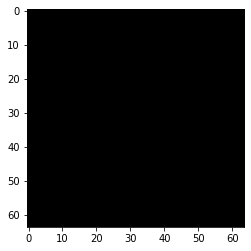

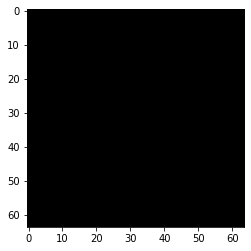

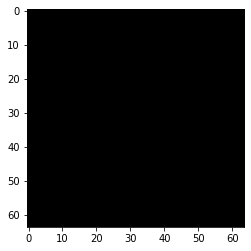

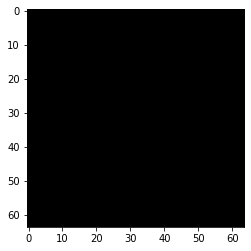

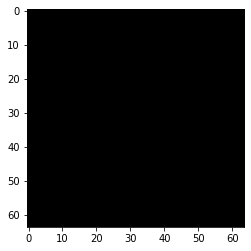

In [21]:
for k in range(5):
    noise = np.random.normal(0, 1, (1, 128))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    #gen_imgs = 0.5 * gen_imgs + 0.5
    
    image = Image.fromarray(((gen_imgs + 1) * 127.5).astype('uint8').reshape(64, 64, 3))

    #plt.imshow(image.array_to_img(gen_imgs[0]))
    plt.imshow(image, interpolation = 'nearest')
    plt.show()




Let's try increasing the number of epochs. 

In [ ]:
%%time

train(epochs=100000, batch_size=32, save_interval=5000)

0 [D loss: 0.696601, acc.: 69.66%] [G loss: 0.691037]
4999 [D loss: 0.210994, acc.: 21.10%] [G loss: 11.246796]
9999 [D loss: 0.167044, acc.: 16.70%] [G loss: 11.212129]
14999 [D loss: 0.173762, acc.: 17.38%] [G loss: 18.470108]
19999 [D loss: 0.171714, acc.: 17.17%] [G loss: 10.855364]
24999 [D loss: 0.200942, acc.: 20.09%] [G loss: 11.016059]
29999 [D loss: 0.173284, acc.: 17.33%] [G loss: 17.709833]
34999 [D loss: 0.203960, acc.: 20.40%] [G loss: 17.743530]
39999 [D loss: 0.239613, acc.: 23.96%] [G loss: 85.253998]
44999 [D loss: 0.176902, acc.: 17.69%] [G loss: 18.253099]
49999 [D loss: 0.473860, acc.: 47.39%] [G loss: 121.332512]
54999 [D loss: 0.167355, acc.: 16.74%] [G loss: 11.463520]
59999 [D loss: 0.256119, acc.: 25.61%] [G loss: 23.481489]
64999 [D loss: 0.170559, acc.: 17.06%] [G loss: 13.293835]
69999 [D loss: 0.384925, acc.: 38.49%] [G loss: 54.657654]
74999 [D loss: 0.178618, acc.: 17.86%] [G loss: 15.691533]
79999 [D loss: 0.181945, acc.: 18.19%] [G loss: 4041.209473]
8

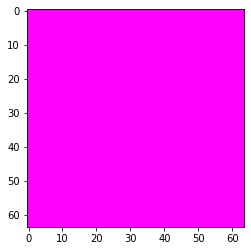

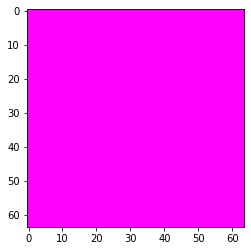

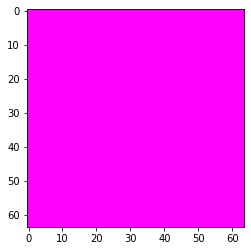

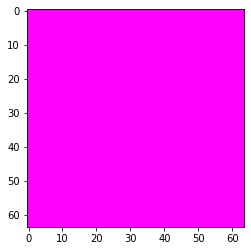

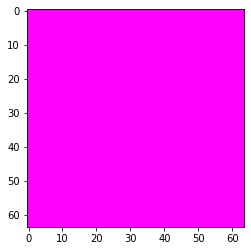

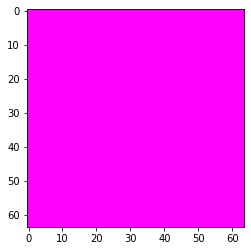

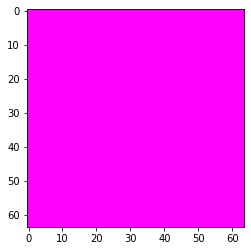

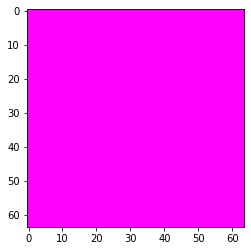

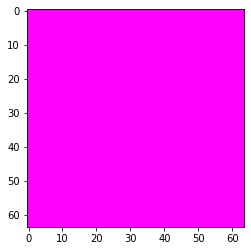

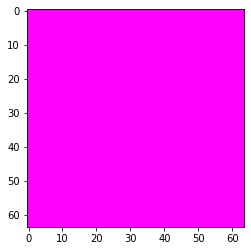

In [ ]:
for k in range(10):
    noise = np.random.normal(0, 1, (1, 128))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    #gen_imgs = 0.5 * gen_imgs + 0.5
    
    image = Image.fromarray(((gen_imgs + 1) * 127.5).astype('uint8').reshape(64, 64, 3))

    #plt.imshow(image.array_to_img(gen_imgs[0]))
    plt.imshow(image, interpolation = 'nearest')
    plt.show()

We moved from black to magenta. Not what we had hoped. Delving deeper into previous work we found some people created their own Adam optimizer which updates weights throughout the model. We will implement such a weight. 

In [23]:
class AdamWithWeightnorm(tf.keras.optimizers.Adam):
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations, K.floatx())))

        t = K.cast(self.iterations + 1, K.floatx())
        lr_t = lr * K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t))

        shapes = [K.get_variable_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):

            # if a weight tensor (len > 1) use weight normalized parameterization
            # this is the only part changed w.r.t. keras.optimizers.Adam
            ps = K.get_variable_shape(p)
            if len(ps)>1:

                # get weight normalization parameters
                V, V_norm, V_scaler, g_param, grad_g, grad_V = get_weightnorm_params_and_grads(p, g)

                # Adam containers for the 'g' parameter
                V_scaler_shape = K.get_variable_shape(V_scaler)
                m_g = K.zeros(V_scaler_shape)
                v_g = K.zeros(V_scaler_shape)

                # update g parameters
                m_g_t = (self.beta_1 * m_g) + (1. - self.beta_1) * grad_g
                v_g_t = (self.beta_2 * v_g) + (1. - self.beta_2) * K.square(grad_g)
                new_g_param = g_param - lr_t * m_g_t / (K.sqrt(v_g_t) + self.epsilon)
                self.updates.append(K.update(m_g, m_g_t))
                self.updates.append(K.update(v_g, v_g_t))

                # update V parameters
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * grad_V
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(grad_V)
                new_V_param = V - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)
                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                # if there are constraints we apply them to V, not W
                if getattr(p, 'constraint', None) is not None:
                    new_V_param = p.constraint(new_V_param)

                # wn param updates --> W updates
                add_weightnorm_param_updates(self.updates, new_V_param, new_g_param, p, V_scaler)

            else: # do optimization normally
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                new_p = p_t
                # apply constraints
                if getattr(p, 'constraint', None) is not None:
                    new_p = p.constraint(new_p)
                self.updates.append(K.update(p, new_p))
        return self.updates

def get_weightnorm_params_and_grads(p, g):
    ps = K.get_variable_shape(p)

    # construct weight scaler: V_scaler = g/||V||
    V_scaler_shape = (ps[-1],)  # assumes we're using tensorflow!
    V_scaler = K.ones(V_scaler_shape)  # init to ones, so effective parameters don't change

    # get V parameters = ||V||/g * W
    norm_axes = [i for i in range(len(ps) - 1)]
    V = p / tf.reshape(V_scaler, [1] * len(norm_axes) + [-1])

    # split V_scaler into ||V|| and g parameters
    V_norm = tf.sqrt(tf.reduce_sum(tf.square(V), norm_axes))
    g_param = V_scaler * V_norm

    # get grad in V,g parameters
    grad_g = tf.reduce_sum(g * V, norm_axes) / V_norm
    grad_V = tf.reshape(V_scaler, [1] * len(norm_axes) + [-1]) * \
             (g - tf.reshape(grad_g / V_norm, [1] * len(norm_axes) + [-1]) * V)

    return V, V_norm, V_scaler, g_param, grad_g, grad_V

def add_weightnorm_param_updates(updates, new_V_param, new_g_param, W, V_scaler):
    ps = K.get_variable_shape(new_V_param)
    norm_axes = [i for i in range(len(ps) - 1)]

    # update W and V_scaler
    new_V_norm = tf.sqrt(tf.reduce_sum(tf.square(new_V_param), norm_axes))
    new_V_scaler = new_g_param / new_V_norm
    new_W = tf.reshape(new_V_scaler, [1] * len(norm_axes) + [-1]) * new_V_param
    updates.append(K.update(W, new_W))
    updates.append(K.update(V_scaler, new_V_scaler))

# data based initialization for a given Keras model
def data_based_init(model, input):
    # input can be dict, numpy array, or list of numpy arrays
    if type(input) is dict:
        feed_dict = input
    elif type(input) is list:
        feed_dict = {tf_inp: np_inp for tf_inp,np_inp in zip(model.inputs,input)}
    else:
        feed_dict = {model.inputs[0]: input}

    # add learning phase if required
    if model.uses_learning_phase and K.learning_phase() not in feed_dict:
        feed_dict.update({K.learning_phase(): 1})

    # get all layer name, output, weight, bias tuples
    layer_output_weight_bias = []
    for l in model.layers:
        trainable_weights = l.trainable_weights
        if len(trainable_weights) == 2:
            W,b = trainable_weights
            assert(l.built)
            layer_output_weight_bias.append((l.name,l.get_output_at(0),W,b)) # if more than one node, only use the first

    # iterate over our list and do data dependent init
    sess = K.get_session()
    for l,o,W,b in layer_output_weight_bias:
        print('Performing data dependent initialization for layer ' + l)
        m,v = tf.nn.moments(o, [i for i in range(len(o.get_shape())-1)])
        s = tf.sqrt(v + 1e-10)
        updates = tf.group(W.assign(W/tf.reshape(s,[1]*(len(W.get_shape())-1)+[-1])), b.assign((b-m)/s))
        sess.run(updates, feed_dict)

In [24]:
def build_generator_2():

    # Random Normal Weight Initialization
    init = RandomNormal(mean = 0.0, stddev = 0.02)

    # Model
    model = Sequential()

    # Start at 4 * 4
    start_shape = 64 * 4 * 4
    model.add(Dense(start_shape, kernel_initializer = init, input_dim = 128))
    model.add(Reshape((4, 4, 64)))
    
    # Upsample => 8 * 8 
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())
    
    # Upsample => 16 * 16 
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())
    
    # Upsample => 32 * 32
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())
    
    # Upsample => 64 * 64
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, padding = "same", kernel_initializer = init))
    model.add(ReLU())
    
    # output
    model.add(Conv2D(3, kernel_size = 3, activation = 'tanh', padding = 'same', kernel_initializer=init))
    #opt = tf.keras.optimizers.Adam(0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = AdamWithWeightnorm(lr = 0.0002, beta_1 = 0.5))
    print(model.summary())

    return model


In [25]:
def build_discriminator_2():

    input_shape = (64, 64, 3)

    # Random Normal Weight Initialization
    init = RandomNormal(mean = 0.0, stddev = 0.02)

    # Define Model
    model = Sequential()

    # Downsample ==> 32 * 32
    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init, input_shape = input_shape))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    # Downsample ==> 16 * 16
    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    # Downsample => 8 * 8
    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    # Downsample => 4 * 4
    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = init))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    
    # Final Layers
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = init))

    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = AdamWithWeightnorm(lr = 0.0002, beta_1 = 0.5))
    
    print(model.summary())

    return model

In [26]:
# Build and compile the discriminator
discriminator_2 = build_discriminator_2()

# Build the generator
generator_2 = build_generator_2()

# The generator takes noise as input and generates imgs
z = Input(shape=(128,))
img = generator_2(z)

# For the combined model we will only train the generator
discriminator_2.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator_2(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=AdamWithWeightnorm(lr = 0.0002, beta_1 = 0.5))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)        

In [27]:
train(epochs=100000, batch_size=32, save_interval=5000)

0 [D loss: 0.343871, acc.: 34.39%] [G loss: 0.693151]
4999 [D loss: 0.265578, acc.: 26.56%] [G loss: 0.619211]
9999 [D loss: 0.397984, acc.: 39.80%] [G loss: 0.607894]
14999 [D loss: 0.280294, acc.: 28.03%] [G loss: 0.594110]
19999 [D loss: 0.277403, acc.: 27.74%] [G loss: 0.578462]
24999 [D loss: 0.371293, acc.: 37.13%] [G loss: 0.568040]
29999 [D loss: 0.267201, acc.: 26.72%] [G loss: 0.559911]
34999 [D loss: 0.327430, acc.: 32.74%] [G loss: 0.552088]
39999 [D loss: 0.346307, acc.: 34.63%] [G loss: 0.543178]
44999 [D loss: 0.309773, acc.: 30.98%] [G loss: 0.541122]
49999 [D loss: 0.329947, acc.: 32.99%] [G loss: 0.535179]
54999 [D loss: 0.326883, acc.: 32.69%] [G loss: 0.534407]
59999 [D loss: 0.391431, acc.: 39.14%] [G loss: 0.527848]
64999 [D loss: 0.292974, acc.: 29.30%] [G loss: 0.523975]
69999 [D loss: 0.330538, acc.: 33.05%] [G loss: 0.520937]
74999 [D loss: 0.299955, acc.: 30.00%] [G loss: 0.520935]
79999 [D loss: 0.268211, acc.: 26.82%] [G loss: 0.516208]
84999 [D loss: 0.358

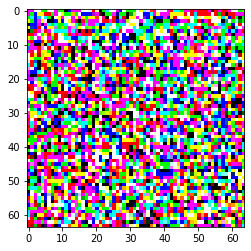

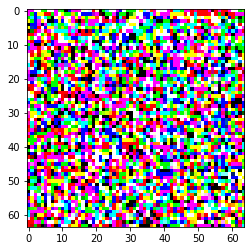

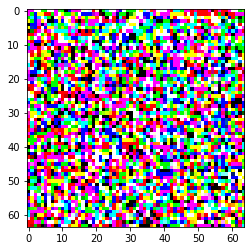

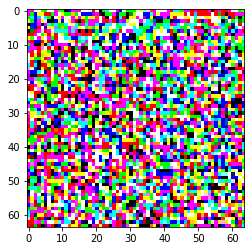

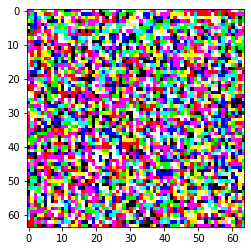

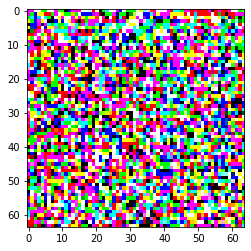

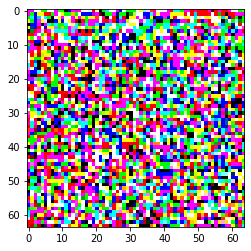

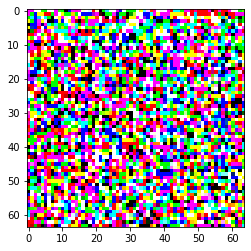

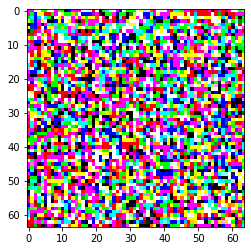

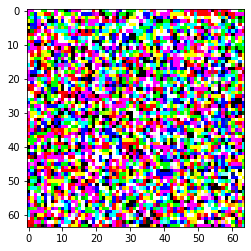

In [28]:
for k in range(10):
    noise = np.random.normal(0, 1, (1, 128))
    gen_imgs = generator_2.predict(noise)
    
    image = Image.fromarray(((gen_imgs + 1) * 127.5).astype('uint8').reshape(64, 64, 3))

    plt.imshow(image, interpolation = 'nearest')
    plt.show()

## Results and Conclusion

Looking at our latest results we see that the algorithm is slowly reaching a point to create images of dogs. The main issue seems to be hardware. Looking at other projects who took a different architectural approach such as https://www.kaggle.com/code/parmarsuraj99/gan-dogs-starter-biggan#Model, the number of epochs is noticeably less but the wall time is 9 hours. 

A big improvement for this in future systems would be to dedicate 8+ hours towards running one model as well as upgrading our architecture. Still, we were able to observe the evolution of our chosen models and walk through the steps to create a GAN for dogs and perhaps expand that to include other creatures as well.   


